In [183]:
import sys
print(sys.version)

3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]


In [184]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Importing the dataset

In [185]:
# Loading the data
ROOT_PATH = "../data/ml-latest-small/"
for path in os.listdir(ROOT_PATH):
  print(path)

links.csv
tags.csv
ratings.csv
README.txt
movies.csv


In [186]:
links = pd.read_csv(os.path.join(ROOT_PATH, "links.csv"))
tags = pd.read_csv(os.path.join(ROOT_PATH, "tags.csv"))
ratings = pd.read_csv(os.path.join(ROOT_PATH, "ratings.csv"))
movies = pd.read_csv(os.path.join(ROOT_PATH, "movies.csv"))

In [187]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [188]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [189]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [190]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


## Explore Dataset

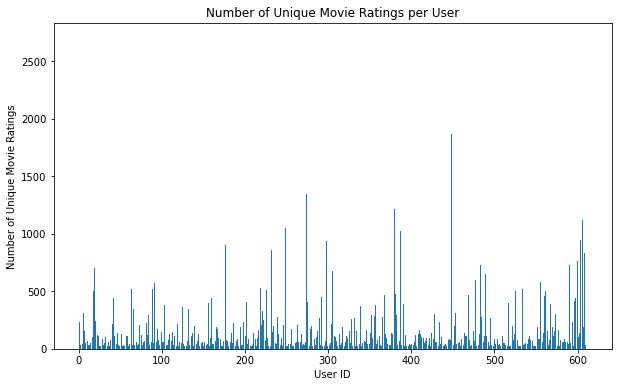

In [191]:
# Count the number of ratings each user has given
user_ratings = ratings.groupby('userId')['movieId'].nunique()

# Create a bar plot
plt.figure(figsize=(10,6)) 
plt.bar(user_ratings.index, user_ratings.values)
plt.xlabel('User ID')
plt.ylabel('Number of Unique Movie Ratings')
plt.title('Number of Unique Movie Ratings per User')
plt.show()

In [192]:
user_ratings.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movieId, dtype: float64

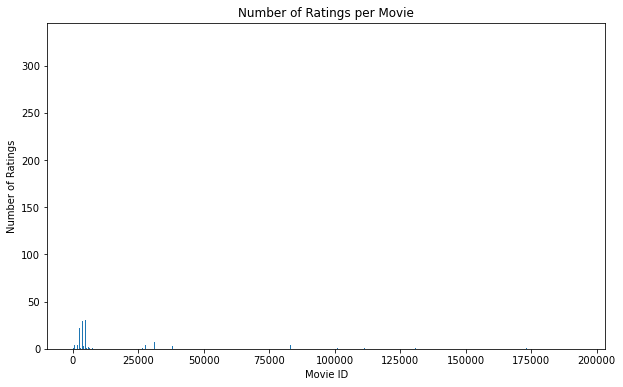

In [193]:
# Count the number of ratings each movie has received
movie_ratings = ratings['movieId'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6)) 
plt.bar(movie_ratings.index, movie_ratings.values)
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Movie')
plt.show()

In [194]:
movie_ratings.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: movieId, dtype: float64

## Preprocessing

In [195]:
# Merge the dataset into a single dataframe
data = pd.merge(ratings, movies, on='movieId')
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [196]:
data.shape

(100836, 6)

In [197]:
# %%time
# genres = data['genres'].str.get_dummies(sep='|')
# data = pd.concat([data, genres], axis=1)
# genres

In [198]:
# Averaging the users ratings for a movie (if repeated)
data = data.groupby(by=['userId','movieId'], as_index=False)['rating'].mean()
data.shape

(100836, 3)

In [199]:
from sklearn.preprocessing import LabelEncoder

# Encode user and movie ids as integer indices
user_enc = LabelEncoder()
item_enc = LabelEncoder()

data['userId'] = user_enc.fit_transform(data['userId'].values)
data['movieId'] = item_enc.fit_transform(data['movieId'].values)

data.head()

,userId,movieId,rating
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


In [200]:
from sklearn.model_selection import train_test_split

# Split into features (X) and target (y)
X = data[['userId', 'movieId']]
y = data['rating']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80668, 2), (20168, 2), (80668,), (20168,))

## Model Preparaation: Matrix Factorisation with Neural Networks

In [201]:
import torch
import torch.nn as nn

class MatrixFactorizationNN(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
        # Initializing the embeddings
        nn.init.xavier_uniform_(self.user_factors.weight)
        nn.init.xavier_uniform_(self.item_factors.weight)
        
    def forward(self, user, item):
        return (self.user_factors(user) * self.item_factors(item)).sum(1)


In [206]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def train(model, train_x, train_y, val_x, val_y, batch_size, n_epochs, lr=1e-6):
    # Creating data loader
    train_dataset = TensorDataset(train_x, train_y)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(val_x, val_y)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Model creation
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # If there's a GPU available, use it, otherwise use the CPU
    device = torch.device('cpu')
    if torch.cuda.is_available():
        print('Training on GPU...')
        device = torch.device('cuda')
        model.to(device)
    else:
        print('Training on CPU...')
        
    model.train()
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    for epoch in tqdm(range(n_epochs)):
        train_loss = 0
        for batch_x, batch_y in train_data_loader:
            user = batch_x[:, 0]
            item = batch_x[:, 1]
            ratings = batch_y
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(user, item)
            loss = criterion(outputs, ratings)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Print / Store the loss value
            # if (i+1) % 100 == 0:
            #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #            .format(epoch+1, n_epochs, i+1, len(data_loader), loss.item()))
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_data_loader)
        history['train_loss'].append(train_loss)
        
         # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_data_loader:
                user = batch_x[:, 0]
                item = batch_x[:, 1]
                ratings = batch_y

                outputs = model(user, item)
                loss = criterion(outputs, ratings)
                val_loss += loss.item()
                
        val_loss = val_loss / len(val_data_loader)
        history['val_loss'].append(val_loss)
        
        model.train()
                
        print(f'Epoch [{epoch+1}/{n_epochs}], train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}')
        
    return model, history


In [203]:
# Convert data to PyTorch tensors
train_x = torch.tensor(X_train.values, dtype=torch.long)
train_y = torch.tensor(y_train.values, dtype=torch.float)
test_x = torch.tensor(X_test.values, dtype=torch.long)
test_y = torch.tensor(y_test.values, dtype=torch.float)

In [207]:
%%time
# Set parameters
EPOCHS = 20
LEARNING_RATE = 5e-4
BATCH_SIZE = 32

n_users = data['userId'].nunique()
n_movies = data['movieId'].nunique()
n_factors = 150

# Initialise model
model = MatrixFactorizationNN(n_users, n_movies, n_factors)
# Start train
model, history = train(model, train_x, train_y, test_x, test_y,
                batch_size=BATCH_SIZE, 
                n_epochs=EPOCHS,
                lr=LEARNING_RATE
                )

Training on CPU...


  5%|▌         | 1/20 [00:28<09:10, 28.97s/it]

Epoch [1/20], train_loss: 10.6824, val_loss: 4.3369


 10%|█         | 2/20 [01:02<09:29, 31.65s/it]

Epoch [2/20], train_loss: 2.3479, val_loss: 1.7853


 15%|█▌        | 3/20 [01:36<09:14, 32.60s/it]

Epoch [3/20], train_loss: 1.1394, val_loss: 1.4229


 20%|██        | 4/20 [02:10<08:52, 33.28s/it]

Epoch [4/20], train_loss: 0.8015, val_loss: 1.3152


 25%|██▌       | 5/20 [02:43<08:16, 33.11s/it]

Epoch [5/20], train_loss: 0.6154, val_loss: 1.2763


 30%|███       | 6/20 [03:16<07:41, 32.98s/it]

Epoch [6/20], train_loss: 0.4849, val_loss: 1.2559


 35%|███▌      | 7/20 [03:50<07:13, 33.31s/it]

Epoch [7/20], train_loss: 0.3858, val_loss: 1.2624


 40%|████      | 8/20 [04:24<06:45, 33.77s/it]

Epoch [8/20], train_loss: 0.3068, val_loss: 1.2643


 45%|████▌     | 9/20 [04:59<06:13, 33.97s/it]

Epoch [9/20], train_loss: 0.2398, val_loss: 1.2713


 50%|█████     | 10/20 [05:33<05:39, 33.97s/it]

Epoch [10/20], train_loss: 0.1845, val_loss: 1.2729


 55%|█████▌    | 11/20 [06:06<05:03, 33.68s/it]

Epoch [11/20], train_loss: 0.1398, val_loss: 1.2842


 60%|██████    | 12/20 [06:39<04:28, 33.52s/it]

Epoch [12/20], train_loss: 0.1058, val_loss: 1.2919


 65%|██████▌   | 13/20 [07:11<03:51, 33.05s/it]

Epoch [13/20], train_loss: 0.0801, val_loss: 1.2974


 70%|███████   | 14/20 [07:42<03:14, 32.39s/it]

Epoch [14/20], train_loss: 0.0621, val_loss: 1.3021


 75%|███████▌  | 15/20 [08:13<02:40, 32.12s/it]

Epoch [15/20], train_loss: 0.0497, val_loss: 1.3104


 80%|████████  | 16/20 [08:45<02:08, 32.10s/it]

Epoch [16/20], train_loss: 0.0415, val_loss: 1.3128


 85%|████████▌ | 17/20 [09:17<01:35, 31.86s/it]

Epoch [17/20], train_loss: 0.0358, val_loss: 1.3117


 90%|█████████ | 18/20 [09:49<01:03, 31.98s/it]

Epoch [18/20], train_loss: 0.0330, val_loss: 1.3157


 95%|█████████▌| 19/20 [10:20<00:31, 31.83s/it]

Epoch [19/20], train_loss: 0.0307, val_loss: 1.3170


100%|██████████| 20/20 [10:52<00:00, 32.61s/it]

Epoch [20/20], train_loss: 0.0295, val_loss: 1.3174
CPU times: user 37min 46s, sys: 4min 34s, total: 42min 20s
Wall time: 10min 52s


## Model Evaluation

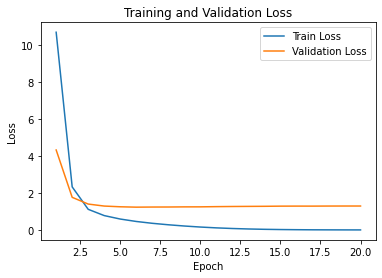

In [208]:
train_loss = history['train_loss']
val_loss = history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [215]:
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_x, test_y, batch_size, binary_thresh=2.5):
    # Creating data loader
    dataset = torch.utils.data.TensorDataset(test_x, test_y)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    # Loss function
    criterion = nn.MSELoss()

    # If there's a GPU available, use it, otherwise use the CPU
    device = torch.device('cpu')
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model.to(device)

    model.eval()
    total_loss = 0.0
    predictions = []
    binary_predictions = []
    binary_ratings = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            user = batch_x[:, 0]
            item = batch_x[:, 1]
            ratings = batch_y
            binary_ratings += [1 if rating >= binary_thresh else 0 for rating in ratings]

            outputs = model(user, item)
            binary_outputs = [1 if output >= binary_thresh else 0 for output in outputs]
            
            loss = criterion(outputs, ratings)
            total_loss += loss.item()
            
            predictions += outputs.tolist()
            binary_predictions += binary_outputs

    # Compute RMSE
    average_loss = total_loss / len(data_loader)
    rmse = math.sqrt(average_loss)
    
    # Compute metrics based on binary output
    accuracy = accuracy_score(binary_ratings, binary_predictions)
    precision = precision_score(binary_ratings, binary_predictions)
    recall = recall_score(binary_ratings, binary_predictions)
    f1 = f1_score(binary_ratings, binary_predictions)
    
    print(f'RMSE: {rmse:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1: {f1:.4f}')
    
    return predictions


predictions = evaluate_model(model, test_x, test_y, BATCH_SIZE, binary_thresh=2.5)

RMSE: 1.1478
Accuracy: 0.8154
Precision: 0.9161
Recall: 0.8652
F1: 0.8899
